In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pickle
from helpers_train import load_train_dataset, train_data_preprocessing

# import importlib
# import helpers
# importlib.reload(helpers)

In [3]:
folder_path = "processed_data/train"
data_df = load_train_dataset(folder_path)
data_df.sample(10)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  8.55file/s]


,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,label
46416,-0.6210,0.1410,-0.7490,-3.3570,30.7010,7.1410,169.3210,42.2260,-34.6560,sitting
12126,0.0580,0.1870,-0.9870,-1.2210,0.0610,0.7320,168.7660,-3.5980,-17.5560,lying
19469,0.1201,-0.7817,0.9331,71.6553,-14.7095,-34.4849,-38.0951,-7.0148,70.3784,walking
23298,0.1560,0.2170,-0.9740,-0.3660,0.9160,1.0380,166.6190,-9.4700,-66.7970,lying
45206,-0.7880,0.0680,-0.6020,0.3050,0.3660,0.6710,172.0900,51.9650,-22.7420,sitting
11147,0.0600,0.1750,-0.9910,-1.5260,0.0610,1.4650,169.3600,-3.6690,-14.3810,lying
41388,0.4080,0.3960,1.6650,-2.0750,-170.0440,191.8950,-178.1050,52.8330,61.3370,climbing
13222,0.1484,-0.9497,-0.2036,-45.5933,-111.0229,-76.2329,-115.8124,7.0752,-168.5687,climbing
7760,0.0470,0.1880,-0.9910,-1.2820,-0.1830,1.4650,168.5800,-3.1530,-2.9500,lying
30976,0.1390,0.2780,-0.9590,-1.1600,0.3050,0.5490,163.1850,-8.4980,-93.9440,lying


In [98]:
data_df.shape

(285905, 10)

In [99]:
features = data_df.iloc[:, :-1]
labels = data_df['label']

print("Features shape: ", features.shape)
print("Labels shape: ", labels.shape)

Features shape:  (285905, 9)
Labels shape:  (285905,)


In [100]:
features

,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ
1,-0.4067,-0.7988,-0.5088,-0.4883,1.5869,1.7090,-122.5250,24.3237,158.3789
2,-0.4067,-0.7988,-0.5088,-0.4883,1.5869,0.7324,-122.5305,24.3182,158.3624
3,-0.4175,-0.7764,-0.4868,-0.4883,1.5869,0.7324,-122.5360,24.3073,158.3405
4,-0.4175,-0.7764,-0.4868,-1.5869,2.0752,-0.4272,-122.5525,24.2908,158.3240
5,-0.4121,-0.7817,-0.4692,-1.5869,2.0752,-0.4272,-122.5690,24.2743,158.3075
...,...,...,...,...,...,...,...,...,...
59098,0.4560,-2.0970,-12.3740,19.7140,-124.5730,-36.9870,156.8900,-30.4600,-98.0260
59099,0.4560,-0.3770,-1.7610,69.1530,-115.3560,-26.9170,157.8680,-29.2350,-98.2180
59100,0.3790,-0.3770,-1.7610,69.1530,-115.3560,-26.9170,158.8240,-28.0040,-98.3770
59101,0.3790,-0.3270,-1.7650,105.5300,-127.2580,-11.6580,160.2190,-26.7190,-98.7070


In [101]:
features_scaled, labels_categorical = train_data_preprocessing(
    features, labels)
print("Features shape: ", features_scaled.shape)
print("Labels shape: ", labels_categorical.shape)

Features shape:  (285905, 9)
Labels shape:  (285905, 5)


In [102]:
# Sliding window parameters
window_size = 128 
stride = 64 

# Generate sequences using sliding windows
sequences = []
labels = []

for i in range(0, len(features_scaled) - window_size + 1, stride):
    window = features_scaled[i:i+window_size]
    label = labels_categorical[i+window_size-1]
    if len(window) == window_size:
        sequences.append(window)
        labels.append(label)


X_sliding = np.array(sequences)
y_sliding = np.array(labels)

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_sliding, y_sliding, test_size=0.2, random_state=42)

In [104]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3572, 128, 9)
X_test shape:  (894, 128, 9)
y_train shape:  (3572, 5)
y_test shape:  (894, 5)


In [105]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dropout, Dense


class CNN1D:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_model(self):
        model = Sequential()
        model.add(Conv1D(filters=256, kernel_size=3,
                         activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, padding='valid'))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.3))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

        return model

In [106]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train.shape[1]

model = CNN1D(input_shape, num_classes).build_model()

# model.summary()

In [107]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

callbacks_list = [checkpoint, early_stop]

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=callbacks_list, verbose=1)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 2.5105 - accuracy: 0.3004
Epoch 1: val_loss improved from inf to 1.35350, saving model to model_checkpoint.h5
14/14 [==============================] - 10s 658ms/step - loss: 2.5105 - accuracy: 0.3004 - val_loss: 1.3535 - val_accuracy: 0.4083
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 1.0132 - accuracy: 0.5647
Epoch 2: val_loss improved from 1.35350 to 0.84115, saving model to model_checkpoint.h5
14/14 [==============================] - 9s 650ms/step - loss: 1.0132 - accuracy: 0.5647 - val_loss: 0.8411 - val_accuracy: 0.6935
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7279
Epoch 3: val_loss improved from 0.84115 to 0.68872, saving model to model_checkpoint.h5
14/14 [==============================] - 9s 649ms/step - loss: 0.6924 - accuracy: 0.7279 - val_loss: 0.6887 - val_accuracy: 0.7271
Epoch 4/50
14/14 [==============================] - ETA: 0s - lo

Prediction


In [108]:
import importlib
import helpers_test
importlib.reload(helpers_test)

<module 'helpers_test' from 'c:\\Decathlon\\CodeGround\\MyProject\\Dog-Activity-Recognition\\helpers_test.py'>

In [109]:
from helpers_test import make_prediction, read_file, test_data_preprocessing, load_test_dataset

In [110]:
# Process Raw Data
file_path = "processed_data/test/test1.csv"
test_data_df = read_file(file_path)
test_data_df

,ax,ay,az,wx,wy,wz,angleX,angleY,angleZ,labels
0,-0.515,0.024,-0.869,20.569,-4.700,28.137,175.567,28.460,96.081,climbing
1,-0.504,0.024,-0.869,20.569,-4.700,28.137,175.616,28.488,95.757,climbing
2,-0.504,0.024,-0.875,22.888,-5.432,26.062,175.682,28.526,95.444,climbing
3,-0.493,0.024,-0.875,22.888,-5.432,26.062,175.770,28.564,95.147,climbing
4,-0.493,0.048,-0.879,24.292,-4.700,22.949,175.875,28.603,94.861,climbing
...,...,...,...,...,...,...,...,...,...,...
16179,-0.460,0.012,-0.893,1.526,2.686,6.653,-179.594,25.598,-0.687,walking
16180,-0.464,0.012,-0.893,1.526,2.686,6.653,-179.599,25.576,-0.758,walking
16181,-0.464,0.010,-0.889,-1.526,0.366,3.845,-179.615,25.565,-0.813,walking
16182,-0.450,0.010,-0.889,-1.526,0.366,3.845,-179.643,25.565,-0.851,walking


In [111]:
# For the file which contains of labels
org_labels = test_data_df['labels']
test_data_df = test_data_df.iloc[:, :-1]

In [112]:
scaled_data = test_data_preprocessing(test_data_df)
# scaled_data

In [113]:
scaled_df = pd.DataFrame(scaled_data, columns=features.columns)
# scaled_df

In [114]:
# Create a sliding window of 10 seconds for the data
window_size = 128
stride = 64

# Generate sequences using sliding windows
sequences = []
labels = []
for i in range(len(scaled_df) - window_size):
    window = scaled_df[i:i+window_size]
    if len(window) == window_size:
        sequences.append(window)

X_sliding = np.array(sequences)

In [115]:
# Make predictions
all_actions, most_occurred_pred = make_prediction(model, X_sliding)
print("All actions: ", all_actions)
print("One action: ", most_occurred_pred)

502/502 [==============================] - 14s 28ms/step
All actions:  ['sitting' 'sitting' 'sitting' ... 'sitting' 'sitting' 'sitting']
One action:  walking


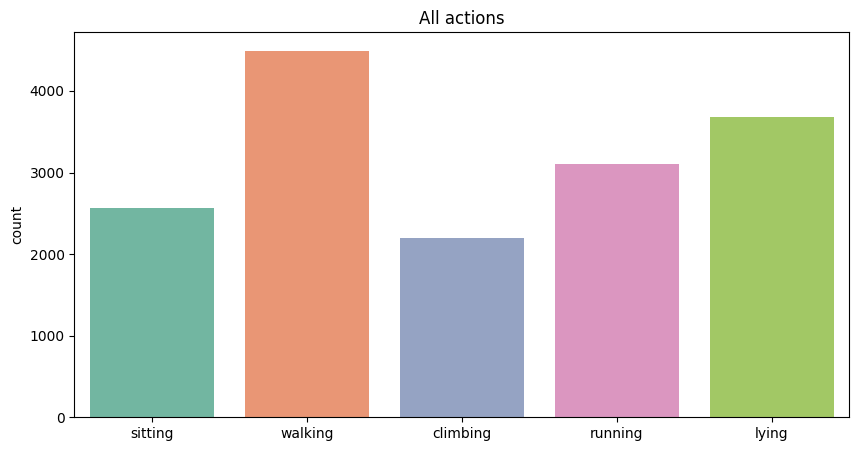

In [116]:
# Draw a freq chart for all actions, different colors for each action
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(x=all_actions, palette="Set2")
plt.title('All actions')
plt.show()

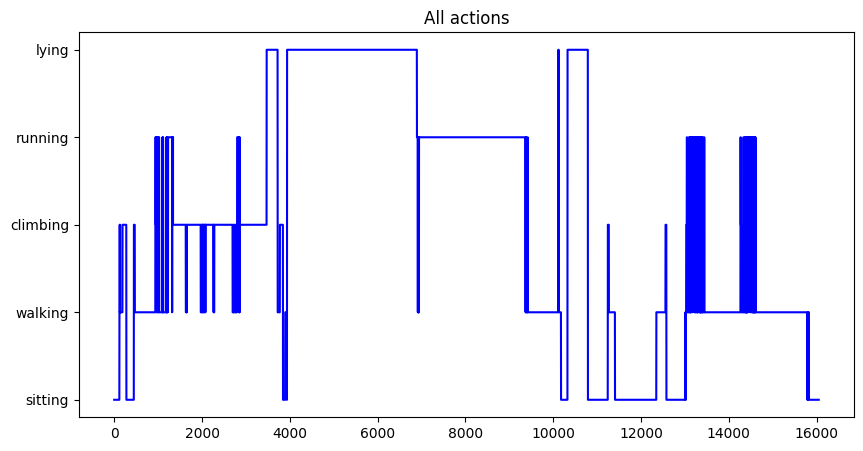

In [117]:
# Draw a line chart for all actions, different colors for each action
plt.figure(figsize=(10, 5))
plt.plot(all_actions, color='blue')
plt.title('All actions')
plt.show()

In [93]:
len(all_actions)

16048

In [119]:
# Accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(org_labels[:16048], all_actions)
# accuracy_score(org_labels, all_actions)

0.7415254237288136

In [120]:
# model.save("utils/model80.h5")